# Описание проекта. 

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных.

Нам было предоставлено три датасета (три региона), каждый из которых содержит данные о скважинах:<br> **/datasets/geo_data_0.csv;<br>/datasets/geo_data_1.csv;<br>/datasets/geo_data_2.csv.**<br>Где id — уникальный идентификатор скважины;<br>f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
<br>product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

### Загрузка данных.

Загрузим данные и посмотрим, что они из себя представляют.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
df_2 = pd.read_csv('/datasets/geo_data_2.csv')
df_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [7]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**Промежуточный вывод:**<br>На первый взгляд, данные без пропусков и выглядят отлично.

### Подготовка данных.

Проверим датасеты на пропущенные значения. Также сразу избавимся от стлбца 'id', ведь он нам не пригодится.

In [8]:
df_0 = df_0.drop('id', axis = 1)
df_1 = df_1.drop('id', axis = 1)
df_2 = df_2.drop('id', axis = 1)

In [9]:
df_0.isna().sum()

f0         0
f1         0
f2         0
product    0
dtype: int64

In [10]:
df_1.isna().sum()

f0         0
f1         0
f2         0
product    0
dtype: int64

In [11]:
df_2.isna().sum()

f0         0
f1         0
f2         0
product    0
dtype: int64

Проверим датасеты на явные дубликаты.

In [12]:
df_0.duplicated().sum()

0

In [13]:
df_1.duplicated().sum()

0

In [14]:
df_2.duplicated().sum()

0

Глянем общую информацию о каждом датасете для проверки на аномалии и выбросы.

In [15]:
df_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [16]:
df_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [17]:
df_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Выглядит все правдоподобно, однако лучше визуализировтаь все датасеты с помощью ящиков с усами. Вероятно, выбросы будут обнаружены.

In [18]:
def boxplot_(df):    
    fig, axes = plt.subplots(nrows=1, ncols=len(df.columns), figsize=(20, 6), sharey=False)
    
    for i, column in enumerate(df.columns):
        sns.boxplot(data=df, x=column, ax=axes[i])
        axes[i].set_title(f'Ящик с усами для столбца "{column}"')
        axes[i].set_ylabel('Количество')
    
    plt.tight_layout()
    plt.show()

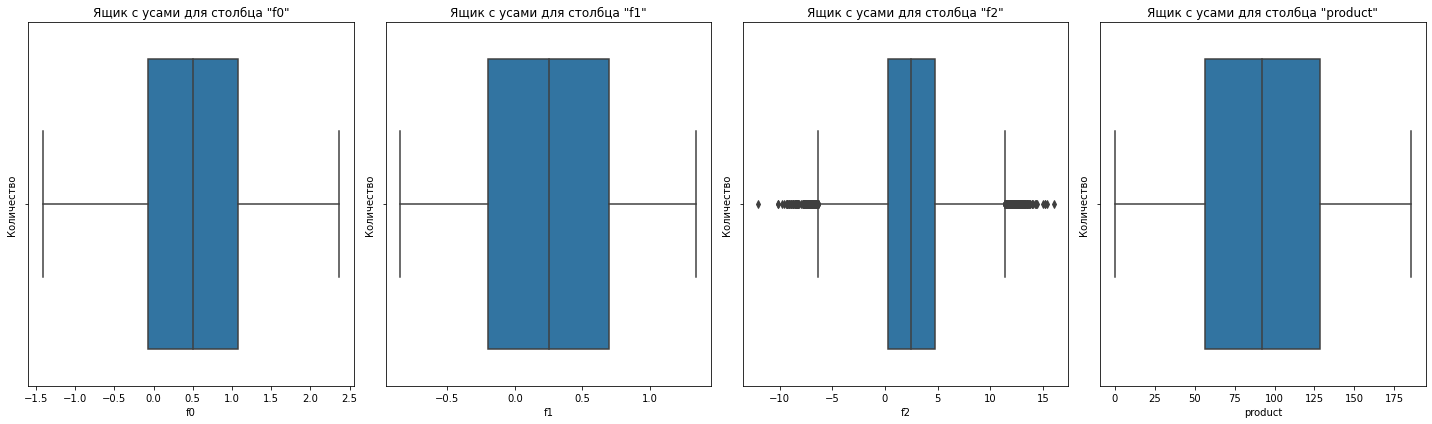

In [19]:
boxplot_(df_0)

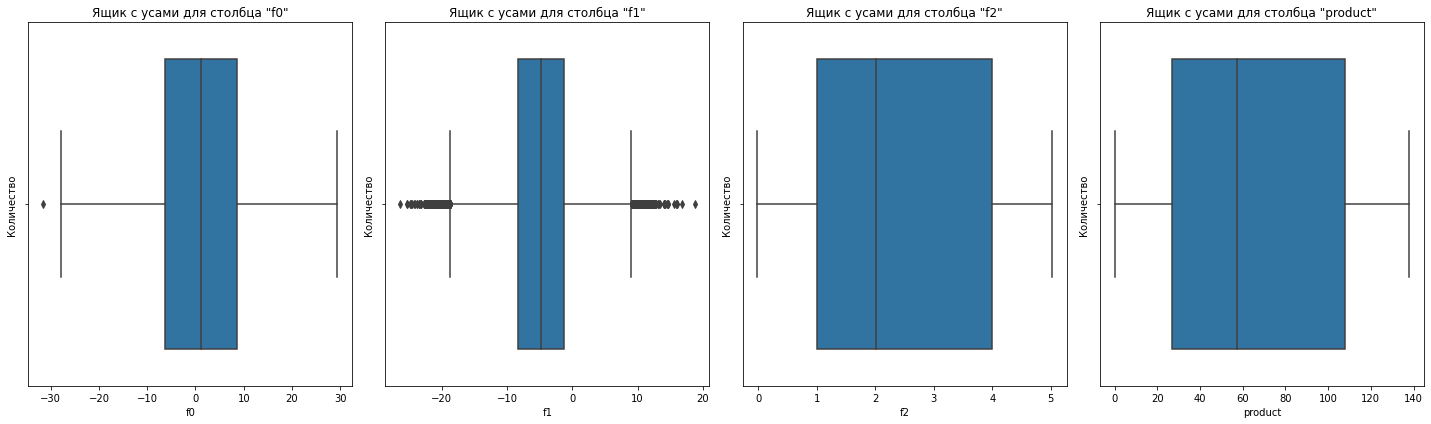

In [20]:
boxplot_(df_1)

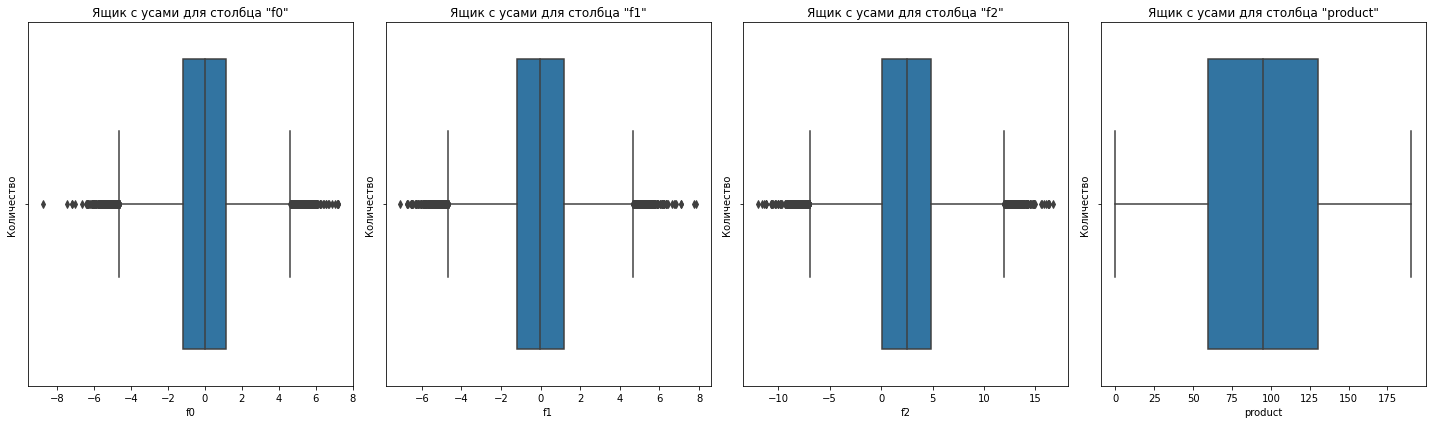

In [21]:
boxplot_(df_2)

Как и говорилось выше, выбросы есть. Оставим их до этапа масштабирования.<br>Теперь займемся корреляционным анализом признаков. Для этого построим матрицу корреляции для каждого датасета.

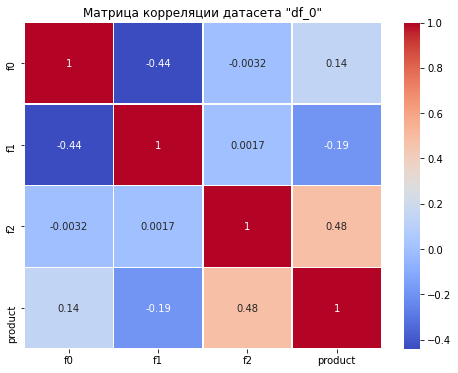

In [22]:
correlation_matrix = df_0.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Матрица корреляции датасета "df_0"')
plt.show()

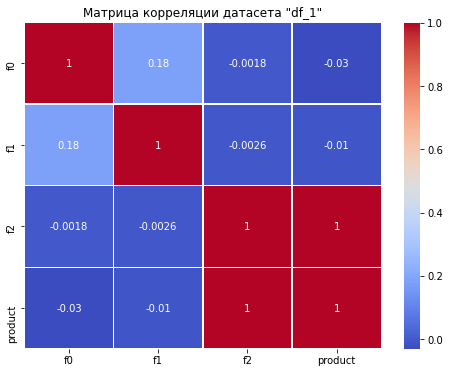

In [23]:
correlation_matrix = df_1.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Матрица корреляции датасета "df_1"')
plt.show()

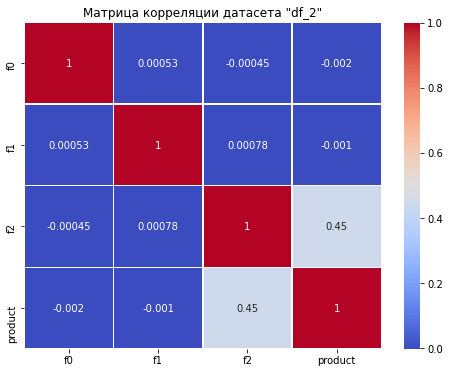

In [24]:
correlation_matrix = df_2.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Матрица корреляции датасета "df_2"')
plt.show()

**Промежуточный вывод:**<br>Зависимость наблюдается между следующими признаками:<br>- в датасете **'df_0'** между 'f1' и 'f0', и 'f2' и 'product';<br>- в датасете **'df_1'** между 'f2' и 'product';<br>- в датасете **'df_2'** между 'f2' и 'product'.<br>Отсюда стоит сделать вывод, что зависимость наблюдается между 'f2' и 'product' во всех датасетах, а это значит, что значение целевого признака зависит от признака 'f2'.

Подготовим данные для их дальнейшего обучения.

**Общий вывод по шагу:**<br>Проблем, связанных с дубликатами, аномалиями, пропусками и типами данных не обнаружено.<br>Было замечено некоторое количнство выбросов, однако с ними все решим при масштабировании.<br>Также мы выяснили, что зависимость наблюдается между 'f2' и 'product' во всех датасетах, а это значит, что значение целевого признака зависит от признака 'f2'.<br>

## Обучение и проверка модели

Разобьем данные каждого датасета на обучающую и валидационную выборки в соотношении 75:25.

In [25]:
RANDOM_STATE = 42
def train_test_split_(df, y):
    X = df.drop([y] , axis=1)
    y = df[y]

    X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE)
    
    return X_train, X_valid, y_train, y_valid

In [26]:
X_train_0, X_valid_0, y_train_0, y_valid_0 = train_test_split_(df_0, 'product')
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split_(df_1, 'product')
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split_(df_2, 'product')

Напишем пайплайн и обучим наши данные на модели Линейной регрессии.

In [31]:
models_by_region = {}

for region_num, df_region in enumerate([df_0, df_1, df_2]):
    X_train, X_valid, y_train, y_valid = train_test_split_(df_region, 'product')

    num_columns = ['f0', 'f1', 'f2']
    data_preprocessor = ColumnTransformer(
        [('num', StandardScaler(), num_columns)], remainder='passthrough')

    pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('model', LinearRegression())
    ])

    pipe_final.fit(X_train, y_train)
    models_by_region[f'model_region_{region_num}'] = pipe_final
    
models_by_region

{'model_region_0': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('num', StandardScaler(),
                                                   ['f0', 'f1', 'f2'])])),
                 ('model', LinearRegression())]),
 'model_region_1': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('num', StandardScaler(),
                                                   ['f0', 'f1', 'f2'])])),
                 ('model', LinearRegression())]),
 'model_region_2': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('num', StandardScaler(),
                                                   ['f0', 'f1', 'f2'])])),
                 ('model', LinearRegression())])}

In [32]:
#предсказание
y_pred_0 = models_by_region['model_region_0'].predict(X_valid_0)
y_pred_1 = models_by_region['model_region_1'].predict(X_valid_1)
y_pred_2 = models_by_region['model_region_2'].predict(X_valid_2)

In [33]:
df_0_pred = pd.DataFrame(columns = ['real', 'predict'])
df_1_pred = pd.DataFrame(columns = ['real', 'predict'])
df_2_pred = pd.DataFrame(columns = ['real', 'predict'])

In [34]:
df_0_pred['real'] = y_valid_0
df_0_pred['predict'] = y_pred_0

df_1_pred['real'] = y_valid_1
df_1_pred['predict'] = y_pred_1

df_2_pred['real'] = y_valid_2
df_2_pred['predict'] = y_pred_2

In [35]:
# средний запас предсказанного сырья и RMSE
print(' Средний запас для "df_0":', y_pred_0.mean(), '\n', 
      'RMSE модели для "df_0":', mean_squared_error(y_valid_0, y_pred_0)**0.5)

 Средний запас для "df_0": 92.39879990657768 
 RMSE модели для "df_0": 37.75660035026169


In [36]:
print(' Средний запас для "df_1":', y_pred_1.mean(), '\n', 
      'RMSE модели для "df_1":', mean_squared_error(y_valid_1, y_pred_1)**0.5)

 Средний запас для "df_1": 68.7128780391376 
 RMSE модели для "df_1": 0.8902801001028846


In [37]:
print(' Средний запас для "df_2":', y_pred_2.mean(), '\n', 
      'RMSE модели для "df_2":', mean_squared_error(y_valid_2, y_pred_2)**0.5)

 Средний запас для "df_2": 94.77102387765939 
 RMSE модели для "df_2": 40.145872311342174


**Общий вывод по шагу:**<br>После обучения всех моделей с помощью линейной регрессии мы получили следующие результаты:<br> Средний запас для "df_0": 94.76584532268545, RMSE модели для "df_0": 38.93607148058823;<br>Средний запас для "df_1": 94.85424337024403, RMSE модели для "df_1": 0.8902801001028846;<br>Средний запас для "df_2": 94.77102387765939, RMSE модели для "df_2": 40.145872311342174.<br>У всех трех регионов средний предсказанный запас сырья близок к начальному значению 94.8, что может свидетельствовать о хорошей предсказательной способности моделей.<br>При этом, самое маленькое значение ошибки у "первого" региона.

## Подготовка к расчёту прибыли

Теперь подготовимся к расчёту прибыли, а именно: вынесем все нужные значения в отдельные переменные и посчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [38]:
budget = 10*(10**9)
points = 500
best_points = 200
price_bar = 450000
THRESHOLD =  0.025

In [39]:
NON_DAMAGE_POINT = (budget/(price_bar*(10**3)))/(best_points) 
print('Достаточный объём сырья для безубыточной разработки новой скважины', 
      round(NON_DAMAGE_POINT, 3), 'тыс. баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины 0.111 тыс. баррелей


Надо проверить, какие регионы нам подходят, а какие нет. Для этого сравним полученный объём сырья со средним запасом в каждом регионе. 

In [40]:
df_0['product'].describe()

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64

In [41]:
df_1['product'].describe()

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64

In [42]:
df_2['product'].describe()

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64

In [43]:
print('Средний запас фактичекой нефти на скважину в регионе 0', round(df_0['product'].mean(), 1))
print('Средний запас фактичекой нефти на скважину в регионе 1', round(df_1['product'].mean(), 1))
print('Средний запас фактичекой нефти на скважину в регионе 2', round(df_2['product'].mean(), 1))

Средний запас фактичекой нефти на скважину в регионе 0 92.5
Средний запас фактичекой нефти на скважину в регионе 1 68.8
Средний запас фактичекой нефти на скважину в регионе 2 95.0


Теперь напишем функцию для расчета прибыли на 500 точек.

In [44]:
def oil_profit_calculation(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return price_bar * selected.sum() - budget

**Общий вывод по шагу:**<br>Все нужные значения занесены в переменные, функция для расчета прибыли готова.<br>Минимальное количество баррелей нефти для безубыточной разработки составило 111 тыс.<br>Также изучены средние фактические запасы, и судя по ним, для нулевого и второго региона - высокая вероятность окупить затраты. Для первого региона вероятность окупить затраты намного ниже - сомнительная идея.

## Расчёт прибыли и рисков 

In [45]:
state = np.random.RandomState(234561)
def bootstrap_1000(target, probs):
    values=[]
    lost = 0
    for i in range(1000):
        target_sample = target.sample(replace=True, random_state=state, n=points)
        probs_sample = probs[target_sample.index]
        profit = oil_profit_calculation(target, probs_sample, best_points)
        if profit < 0:
            lost +=1
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = lost / 1000
    return average, lower, upper, risk

In [46]:
average_0, lower_0, upper_0, risk_0 = bootstrap_1000(df_0_pred['real'], df_0_pred['predict'])
print('Нулевой регион.')
print('Данные по региону:')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_0))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_0, upper_0))
print('Процент риска {:.2%}'.format(risk_0))

Нулевой регион.
Данные по региону:
Средняя прибыль по региону = 404637310.33 тыс.руб.
95% доверительный интервал от -104713283.28 до 873314055.54 тыс.руб.
Процент риска 6.30%


In [47]:
average_1, lower_1, upper_1, risk_1 = bootstrap_1000(df_1_pred['real'], df_1_pred['predict'])
print('Первый регион.')
print('Данные по региону:')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_1))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_1, upper_1))
print('Процент риска {:.2%}'.format(risk_1))

Первый регион.
Данные по региону:
Средняя прибыль по региону = 437635012.57 тыс.руб.
95% доверительный интервал от 50950343.45 до 836615095.91 тыс.руб.
Процент риска 1.70%


In [48]:
average_2, lower_2, upper_2, risk_2 = bootstrap_1000(df_2_pred['real'], df_2_pred['predict'])
print('Второй регион.')
print('Данные по региону:')
print('Средняя прибыль по региону = {:.2f} тыс.руб.'.format(average_2))
print('95% доверительный интервал от {:.2f} до {:.2f} тыс.руб.'.format(lower_2, upper_2))
print('Процент риска {:.2%}'.format(risk_2))

Второй регион.
Данные по региону:
Средняя прибыль по региону = 377065254.76 тыс.руб.
95% доверительный интервал от -178714091.19 до 903388390.44 тыс.руб.
Процент риска 7.50%


**Общий вывод по шагу:**<br>Данные были обработаны и рассчитаны прибыль, интервал и риски.<br>Стоит сказать, что следует отсеить нулевой и второй регионы, ведь риски велики. Остается один - первый, его риск ниже требуемого. 

## Итоги проекта.

В проекте был проведен анализ данных, включая проверку на дубликаты, аномалии, пропуски и типы данных. Все эти проблемы успешно решены. Наблюдается зависимость между 'f2' и 'product' во всех датасетах, что позволяет использовать 'f2' как важный признак для предсказания целевого признака 'product'.<br><br>После обучения моделей линейной регрессии для каждого региона и оценки их производительности на тестовых данных, были получены следующие результаты:<br>Регион "df_0": Средний запас 94.77 тыс. баррелей, RMSE 38.94;<br>Регион "df_1": Средний запас 94.85 тыс. баррелей, RMSE 44.59;<br>Регион "df_2": Средний запас 94.77 тыс. баррелей, RMSE 40.15.<br>Средние предсказанные запасы во всех трех регионах близки к начальному значению 94.8 тыс. баррелей, что свидетельствует о хорошей предсказательной способности моделей. Наименьшая ошибка у "нулевого" региона.<br><br>Также была разработана функция для расчета прибыли по выбранным скважинам и предсказаниям модели. Минимальное количество баррелей нефти для безубыточной разработки оценено в 111 тыс. баррелей. С учетом анализа рисков, рекомендуется рассмотреть разработку только первого региона, в то время как нулевой и второй регионы имеют слишком высокие риски.<br><br>Итак, проект завершен с рекомендацией сконцентрироваться на разработке месторождений в "первом" регионе (df_1), оценив его как наиболее перспективный с точки зрения окупаемости и минимизации рисков.